In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from igraph import Graph
import igraph as ig

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error

In [84]:
def get_ranks(league):
    ranks = pd.read_csv('resources/{}_rankings.csv'.format(league))
    ranks = ranks.fillna(100)
    ranks = ranks.set_index('Club_name')
    return ranks

In [3]:
leagues = pd.read_csv('resources/club_league.csv')

def get_league_teams(league, sellers=True):
    lea = leagues[leagues['league_name']==league]['club_name'].values
    if sellers:
        lea = np.append(lea, [l+'_seller' for l in lea])
    return lea

In [27]:
def get_centrality(g, club, league, weights='weight'):
    
    ids = np.array(g.vs['id'])
    buyer_idx  = np.where(ids == club)[0]
    seller_idx = np.where(ids == club+'_seller')[0]
    league_idxs = np.where(np.isin(ids, league))[0]

    # If you pass weighs=None, it will just work with the normal degrees as in the original paper
    strengths = np.array(g.strength(weights=weights))
    strengths_league = strengths[league_idxs]
    strenght_buyer = strengths[buyer_idx]
    strenght_seller = strengths[seller_idx]
    
    z_buyer  = (strenght_buyer  - np.mean(strengths_league))/(np.std(strengths_league)+1.1e-07)
    z_seller = (strenght_seller - np.mean(strengths_league))/(np.std(strengths_league)+1.1e-07)

    # Return a vector with three elements: the centrality for the buyer, for the seller and the total
    z = np.zeros(3)
    
    if buyer_idx.size > 0:  z[0] = z_buyer
    if seller_idx.size > 0: z[1] = z_seller
    z[2] = z[0]+z[1] # Not sure if this is the best way to combine the two indicators tho
    
    return z

In [28]:
def get_centrality_years(teams, league, year_from, year_to):

    years = [year for year in range(year_from, year_to+1, 1)]
    league_teams = get_league_teams(league)

    fee  = np.zeros((len(teams), len(years), 3))
    freq = np.zeros((len(teams), len(years), 3))
    for i, year in enumerate(years):

        g_fee  = Graph.Load('nets/{}/fee_net.net'.format(year))
        g_freq = Graph.Load('nets/{}/freq_net.net'.format(year))

        for j, t in enumerate(teams):
            fee[j, i]  = get_centrality(g_fee, t, league_teams)
            freq[j, i] = get_centrality(g_freq, t, league_teams)
        
    return fee, freq

In [169]:
def get_rank_centrality_corr(major_leagues, year_from, year_to):
    correlations = []
    
    for l in major_leagues:

        ranks = get_ranks(l)
        teams = ranks.index.to_numpy()

        temp_fee, temp_freq = get_centrality_years(teams, l, year_from, year_to)

        league_cent = []
        league_rank = []

        for i, t in enumerate(teams):
            # Change the last index: 0 buyer, 1 seller, 2 combined
            # Change between temp_freq and temp_fee to use one of the two approaches
            cent = temp_fee[i,:,2] 
            try:
                rankings = ranks.loc[t].values
            except:
                print(i, t)
                continue

            idx = np.intersect1d(np.where(cent!=0),np.where(rankings!=100))

            league_cent.extend(cent[idx])
            league_rank.extend(rankings[idx])

        corr = stats.pearsonr(league_cent, league_rank)[0]
        print('Rank-Centrality correaltion for league {}: {:.2f}'.format(l, corr))
        correlations.append(corr)
        
    return correlations

In [199]:
def get_centrality_position_prob(major_leagues, year_from, year_to, positions=4):
    
    probs = [] 
    for l in major_leagues:
    
        ranks = get_ranks(l)
        teams = ranks.index.to_numpy()
        years = [year for year in range(year_from, year_to+1, 1)]

        fee, freq = get_centrality_years(teams, l, year_from, year_to)
        # best 5 teams for each year (last index: 0-buyer,1-seller,2-combined)
        best_centralities = np.argsort(fee[:, :, 2], axis=0)[::-1]
        best_centralities = best_centralities[:positions,:]

        # retrieve the number of teams with the highest centrality that were also in the highest ranking positions
        counts = 0 
        for i,y in enumerate(years):
            y_ranks = ranks[str(y)].sort_values()[:positions]
            counts += len(set(y_ranks.keys())&set(teams[best_centralities[:,i]]))
            
        prob = counts/(positions*len(years))
        #print('Probability to see most central teams in highest positions in {}: {:.2f}'.format(l, prob))
        #print(round(prob, 2))
        probs.append(prob)
    return probs

## Correlation between centrality and ranking

#### All the data

In [183]:
major_leagues = ['1 Bundesliga','Liga Nos', 'Premier League',  'Primera Division', 'Serie A']

In [172]:
_ = get_rank_centrality_corr(major_leagues, 1992, 2019)
print('\n')
_ = get_centrality_position_prob(major_leagues, 1992, 2019, positions=4)

Rank-Centrality correaltion for league Premier League: -0.45
Rank-Centrality correaltion for league Serie A: -0.58
Rank-Centrality correaltion for league 1 Bundesliga: -0.41
Rank-Centrality correaltion for league Primera Division: -0.55
Rank-Centrality correaltion for league Liga Nos: -0.53


In [204]:
mj_ps = {m:[] for m in major_leagues}
for n in range(1, 11):
    print(n)
    probs = get_centrality_position_prob(major_leagues, 1992, 2019, positions=n)
    for i, m in enumerate(major_leagues):
        mj_ps[m].append(probs[i])

1
2
3
4
5
6
7
8
9
10


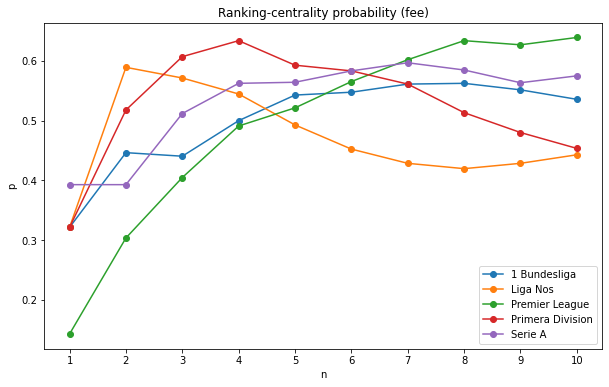

In [220]:
plt.figure(figsize=(10,6))
for i, m in enumerate(major_leagues): 
    plt.plot(mj_ps[m], '-o', label=m)
    
plt.title('Ranking-centrality probability (fee)')
plt.xlabel('n')
plt.ylabel('p')
plt.xticks(range(0, 10), range(1, 11))
plt.legend()
plt.savefig('ranking_centrality_prob.png')
plt.show()

Comments about correlation:

- a negative correlation means that the higher the centrality, the lower the rank; actually, since the highest rank is 1, when we have an high NEGATIVE correlation, this means that the importance in the market and the success in the league are high correlated
- better correlations are given if we consider the only the fee method and we combine the values for buyers and sellers just summing them
- In Serie A and Primera Division there is an higher correlation between the importance in the market and the success in the league -> Premier League and Bundesliga are less money-based?

Comments about probabilities:
- the shown probability measures how likely it is that the most central teams in the market are in the first positions of the leagues
- for example, in Serie A in the 50% of the cases the first 5 positions were occupied by the 5 most important teams in the market
- also in this case the Premier League seems to bee the most dynamic league

#### Pre-Bosman

In [121]:
_ = get_rank_centrality_corr(major_leagues, 1992, 1995)
print('\n')
_ = get_centrality_position_prob(major_leagues, 1992, 1995)

Rank-Centrality correaltion for league Premier League: -0.38
Rank-Centrality correaltion for league Serie A: -0.60
Rank-Centrality correaltion for league 1 Bundesliga: -0.38
Rank-Centrality correaltion for league Primera Division: -0.47


Probability to see most central teams in highest positions in Premier League: 0.25
Probability to see most central teams in highest positions in Serie A: 0.45
Probability to see most central teams in highest positions in 1 Bundesliga: 0.55
Probability to see most central teams in highest positions in Primera Division: 0.45


#### Early era


In [122]:
_ = get_rank_centrality_corr(major_leagues, 1996, 1999)
print('\n')
_ = get_centrality_position_prob(major_leagues, 1996, 1999)

Rank-Centrality correaltion for league Premier League: -0.22
Rank-Centrality correaltion for league Serie A: -0.36
Rank-Centrality correaltion for league 1 Bundesliga: -0.64
Rank-Centrality correaltion for league Primera Division: -0.52


Probability to see most central teams in highest positions in Premier League: 0.30
Probability to see most central teams in highest positions in Serie A: 0.50
Probability to see most central teams in highest positions in 1 Bundesliga: 0.65
Probability to see most central teams in highest positions in Primera Division: 0.60


#### Mature era

In [123]:
_ = get_rank_centrality_corr(major_leagues, 2000, 2010)
print('\n')
_ = get_centrality_position_prob(major_leagues, 2000, 2010)

Rank-Centrality correaltion for league Premier League: -0.31
Rank-Centrality correaltion for league Serie A: -0.42
Rank-Centrality correaltion for league 1 Bundesliga: -0.34
Rank-Centrality correaltion for league Primera Division: -0.43


Probability to see most central teams in highest positions in Premier League: 0.16
Probability to see most central teams in highest positions in Serie A: 0.53
Probability to see most central teams in highest positions in 1 Bundesliga: 0.53
Probability to see most central teams in highest positions in Primera Division: 0.58


#### Contemporary

In [129]:
_ = get_rank_centrality_corr(major_leagues, 2010, 2019)
print('\n')
_ = get_centrality_position_prob(major_leagues, 2010, 2019)

Rank-Centrality correaltion for league Premier League: -0.31
Rank-Centrality correaltion for league Serie A: -0.43
Rank-Centrality correaltion for league 1 Bundesliga: -0.36
Rank-Centrality correaltion for league Primera Division: -0.44


Probability to see most central teams in highest positions in Premier League: 0.16
Probability to see most central teams in highest positions in Serie A: 0.48
Probability to see most central teams in highest positions in 1 Bundesliga: 0.48
Probability to see most central teams in highest positions in Primera Division: 0.52


## Predict ranking from centrality

Idea: use the centrality measure to predict the ranking of the teams. Use the period from 1992 to 2015 for training, predict on the period 2015-2019. Use both the seller and buyer information and both the frequency and fee approaches in order to have 4 features. Since it is a regression problem, the mean absolute error can be used for evaluation.

In [227]:
def get_rank_centrality(league, year_from, year_to):  
    ranks = get_ranks(league)
    teams = ranks.index.to_numpy()
    temp_fee, temp_freq = get_centrality_years(teams, league, year_from, year_to)
    league_cent = []
    league_rank = []
    for i, t in enumerate(teams):
        cent = np.hstack((temp_fee[i,:,:2], temp_freq[i,:,:2])) 
        try:
            rankings = ranks.loc[t].values
        except:
            print(i, t)
            continue  
        idx = np.intersect1d(np.where(np.sum(cent, axis=1)!=0),np.where(rankings!=100))
        if len(league_cent)==0:
            league_cent = cent[idx]
        else:
            league_cent = np.vstack((league_cent, cent[idx]))    
        league_rank.extend(rankings[idx])    
    return league_cent, league_rank

In [232]:
def get_prediction_error(leagues):
    errors = []
    for league in leagues:
        print('Predicting ', league)
        X_train, y_train = get_rank_centrality(league, 1992, 2015)
        X_test, y_test = get_rank_centrality(league, 2015, 2019)
        print('Train size: {}, Test size: {}'.format(X_train.shape[0], X_test.shape[0]))
        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)
        svr = SVR(kernel = 'rbf')
        svr.fit(X_train, y_train)
        y_predict = svr.predict(X_test)
        error = mean_absolute_error(y_test, y_predict)
        print('Mean Absolute Error: {:.2f}\n'.format(error))
        errors.append(error)
    return errors

In [233]:
major_leagues = ['1 Bundesliga','Liga Nos', 'Premier League',  'Primera Division', 'Serie A']
_ = get_prediction_error(major_leagues)

Predicting  1 Bundesliga
Train size: 420, Test size: 69
Mean Absolute Error: 3.84

Predicting  Liga Nos
Train size: 176, Test size: 38
Mean Absolute Error: 2.89

Predicting  Premier League
Train size: 470, Test size: 92
Mean Absolute Error: 5.69

Predicting  Primera Division
Train size: 408, Test size: 65
Mean Absolute Error: 3.71

Predicting  Serie A
Train size: 415, Test size: 81
Mean Absolute Error: 4.42



**Comments**: Bundesliga and Primer Division are the most predictible leagues, Premier League the more unpredictible ones. The error is quite low expecially in Primera Division and 1 Bundesliga, but this could be derived by the fact that is very easy to predict in these leagues the teams at the top. 